In [32]:
# Import the generator
from h5imagegenerator import HDF5ImageGenerator

import numpy as np

# Some keras stuff
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler

# The image transformation pipeline (optional)
from albumentations import (
    Compose, ShiftScaleRotate
)

# Matplot
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')  
plt.style.use('seaborn-dark')
%matplotlib inline

In [33]:
# (Optional) Declare a transformation pipeline (data augmentation)
myAugmenter = Compose([
        ShiftScaleRotate(
            shift_limit=0.0225,
            scale_limit=0.06,
            rotate_limit=30)
    ])

# Instanciate a train generator
train_gen = HDF5ImageGenerator(
    src= '/storage/datasets/mnist_train.h5',
    num_classes=10,
    scaler=True,
    labels_encoding='smooth',
    smooth_factor=0.1,
    batch_size=128,
    augmenter=myAugmenter)

# Instanciate a test generator
val_gen = HDF5ImageGenerator(
    src= '/storage/datasets/mnist_test.h5',
    num_classes=10,
    scaler=True,
    labels_encoding='smooth',
    smooth_factor=0.1,
    batch_size=128)

### Network

In [34]:
from keras.models import Model
from keras import Input
from keras import layers

class CustomNet(object):
    @staticmethod
    def build(width, height, num_classes, depth=3):
        input_shape = (height, width, depth)
        chan_dim = -1

        input_tensor = Input(shape=input_shape)
        x = layers.SeparableConv2D(64,  (5, 5), padding='same', activation='relu')(input_tensor)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.SeparableConv2D(128, (5, 5), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.1)(x)

        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

        '''
        Flat the last output volume
        into a column vector
        '''
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization(axis=chan_dim)(x)

        '''
        Add a final fully connected layer:
        There are as many neurons as there are outputs (10 -> [0..9])
        '''
        output_tensor = layers.Dense(num_classes, activation='softmax')(x)

        model = Model(input_tensor, output_tensor)

        return model

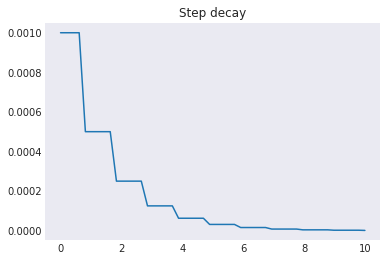

In [36]:
num_epochs = 10

init_lr = 0.001

def step_decay(epoch):
    factor    = 0.5
    drop_rate = 5

    return float(init_lr * (factor ** np.floor((1 + epoch) / drop_rate)))

x = np.linspace(0, num_epochs)
fx = [float(init_lr * (0.5 ** np.floor((1 + i) / 5))) for i in range(len(x))]
plt.plot(x, fx)
plt.title(label='Step decay')
plt.show()

### Training

In [37]:
model = CustomNet.build(
    width=28,
    height=28,
    num_classes=10,
    depth=1
)

rms = RMSprop(learning_rate=init_lr, rho=0.9)

callbacks = [
    LearningRateScheduler(step_decay)
]

model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=rms
)

h = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=callbacks,
    workers=10,
    use_multiprocessing=True,
    verbose=1,
    epochs=num_epochs
)

Epoch 1/10
469/469 [==============================] - 41s 88ms/step - loss: 0.6346 - accuracy: 0.9640 - val_loss: 2.3902 - val_accuracy: 0.4033
Epoch 2/10
469/469 [==============================] - 38s 80ms/step - loss: 0.5560 - accuracy: 0.9877 - val_loss: 0.5750 - val_accuracy: 0.9786
Epoch 3/10
469/469 [==============================] - 38s 80ms/step - loss: 0.5418 - accuracy: 0.9912 - val_loss: 0.5117 - val_accuracy: 0.9933
Epoch 4/10
469/469 [==============================] - 38s 80ms/step - loss: 0.5344 - accuracy: 0.9926 - val_loss: 0.5132 - val_accuracy: 0.9942
Epoch 5/10
469/469 [==============================] - 38s 80ms/step - loss: 0.5238 - accuracy: 0.9955 - val_loss: 0.5083 - val_accuracy: 0.9957
Epoch 6/10
469/469 [==============================] - 37s 80ms/step - loss: 0.5221 - accuracy: 0.9957 - val_loss: 0.5052 - val_accuracy: 0.9963
Epoch 7/10
469/469 [==============================] - 38s 80ms/step - loss: 0.5202 - accuracy: 0.9963 - val_loss: 0.5186 - val_accuracy:

### Viz/Evaluate

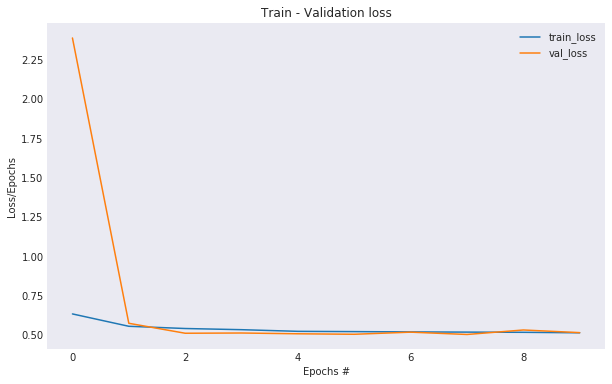

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, num_epochs), h.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), h.history['val_loss'], label='val_loss')

plt.title('Train - Validation loss')
plt.ylabel('Loss/Epochs')
plt.xlabel('Epochs #')
plt.legend()

plt.show()

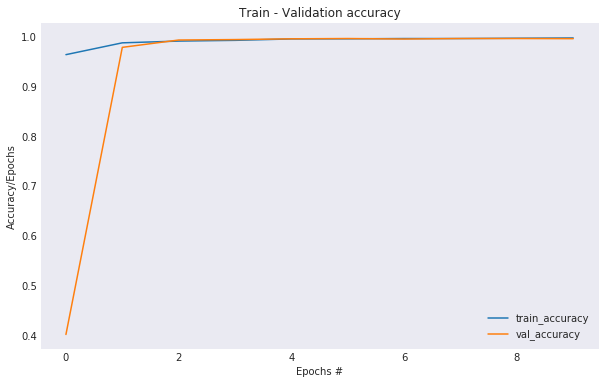

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, num_epochs), h.history['accuracy'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), h.history['val_accuracy'], label='val_accuracy')

plt.title('Train - Validation accuracy')
plt.ylabel('Accuracy/Epochs')
plt.xlabel('Epochs #')
plt.legend()

plt.show()